<a href="https://colab.research.google.com/github/soumyadiptapete/PINN_inversion/blob/main/RLC_pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.python.ops import math_ops
import keras.backend as K
import numpy as np

from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import math

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
1/1 [==============================] - 0s 69ms/step


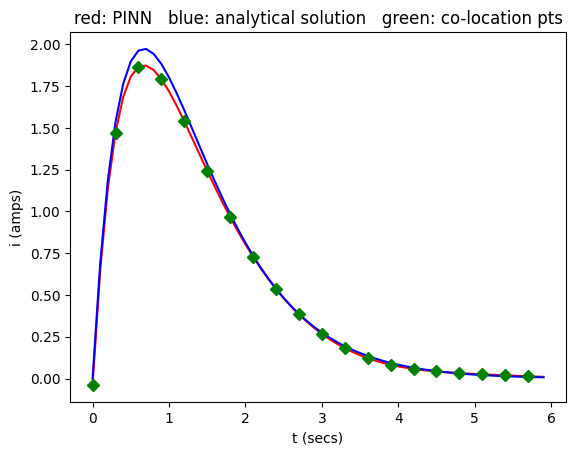

In [ ]:
# Hyperparameters
batch_size = 1
epochs = 60
optimizer = Adam(learning_rate=0.001)
weight_init = RandomNormal()

# Build model
inputs = tf.keras.Input(shape=(1,))
x = layers.Dense(128, activation='gelu', kernel_initializer=weight_init,
                 kernel_regularizer=None)(inputs)
x = layers.Dense(128, activation='gelu', kernel_initializer=weight_init,
                 kernel_regularizer=None)(x)
output = layers.Dense(1, activation='linear', kernel_initializer=weight_init)(x)
model = tf.keras.Model(inputs, output)

# circuit parameters (choose one set)

# under-damped parameters set
# R = 1.2  # resistance, ohm
# L = 1.5  # inductance, H
# C = 0.3  # capacitance, F
# VC_0 = 12.0  # volts, initial capacitor voltage

# critically-damped parameters set
R = 4.47  # resistance, ohm
L = 1.5  # inductance, H
C = 0.3  # capacitance, F
VC_0 = 12.0  # volts, initial capacitor voltage

# over-damped parameter set
# R = 6.0  # resistance, ohm
# L = 1.5  # inductance, H
# C = 0.3  # capacitance, F
# VC_0 = 12.0  # volts, initial capacitor voltage

# co-location points
t_coloc = np.arange(0, 6.0, 0.3)  # define domain

# initial conditions:
   #  f(t) initial conditions
t_init = np.array([0.0])  # time, sec
i_init = np.array([0.0])  # current, A

   #  f'(t) initial conditions
t_init2 = np.array([0.0])  # time, sec
v_init2 = np.array([VC_0])  # d/dt(i) * L = VC_0

# Step function
def step(t_coloc, t_init, i_init, t_init2, i_init2):
    t_coloc = tf.convert_to_tensor(t_coloc)
    t_coloc = tf.reshape(t_coloc, [batch_size, 1])  # required by keras input
    t_coloc = tf.Variable(t_coloc, name='t_coloc')
    with tf.GradientTape(persistent=True) as tape:

        # model_loss1: initial condition i_init @ t_init -> f(t) initial condition
        pred_init = model(t_init)
        model_loss1 = math_ops.squared_difference(pred_init, i_init)

        # model_loss3: initial condition i_init2 @ t_init2 -> f'(t) initial condition
        t_init2 = tf.convert_to_tensor(t_init2)
        t_init2 = tf.reshape(t_init2, [1, 1])
        t_init2 = tf.Variable(t_init2, name='t_init2')
        pred_init2 = model(t_init2)
        dfdx = tape.gradient(pred_init2, t_init2)  # f'(t)
        vl = dfdx * tf.cast(L, tf.float64)  # inductor voltage due to dfdx
        model_loss3 = math_ops.squared_difference(vl, v_init2)
        model_loss3 = tf.cast(model_loss3, tf.float32)

        # 1st and 2nd order gradients for co-location pts
        with tf.GradientTape(persistent=True) as tape2:
            pred_y = model(t_coloc)
            dfdx = tape2.gradient(pred_y, t_coloc)  # f'(t)
        dfdx2 = tape2.gradient(dfdx, t_coloc)  # f"(t)

        # model_loss2: collocation points
        pred_y = tf.cast(pred_y, tf.float64)
        residual = dfdx2 + dfdx * (R / L) + pred_y / (L * C)
        model_loss2 = K.mean(math_ops.square(residual), axis=-1)
        model_loss2 = tf.cast(model_loss2, tf.float32)

        #total loss
        model_loss = model_loss1 + model_loss2 + model_loss3

        trainable = model.trainable_variables
        model_gradients = tape.gradient(model_loss, trainable)

        # Update model
        optimizer.apply_gradients(zip(model_gradients, trainable))

# Training loop
bat_per_epoch = math.floor(len(t_coloc) / batch_size)
for epoch in range(epochs):
    print(f'Epoch {epoch}')
    for i in range(bat_per_epoch):
        n = i * batch_size
        step(t_coloc[n:n + batch_size], t_init, i_init, t_init2, v_init2)

# compare PINN results vs analytical results
num_test_pts = 60
t_test = np.zeros(num_test_pts)
i_test = np.zeros(num_test_pts)
i_calc = np.zeros(num_test_pts)
i_train = model.predict(t_coloc)  # for plotting co-location pts

alpha = R / (2 * L)
for i in range(num_test_pts):
    t_test[i] = i / 10.0  # total time = t_test[num_test_pts]

    # PINN results
    i_test[i] = model.predict([t_test[i]])  # PINN results

    # analytical results for comparison to PINN result
    # choose one matching the chosen circuit parameter set
    # i_calc[i] = 5.57 * math.exp(-0.4 * t_test[i]) * np.sin(1.44 * t_test[i])  # under-damped
    i_calc[i] = (VC_0 / L) * t_test[i] * math.exp(-1 * alpha * t_test[i])  # critically-damped
    # i_calc[i] = 3.0 * (math.exp(-0.67 * t_test[i]) - math.exp(-3.33 * t_test[i]))  # over-damped

#  plt.plot(x_test, y_test, 'r', x_test, y_calc, 'b')
plt.plot(t_test, i_test, 'r', t_test, i_calc, 'b', t_coloc, i_train, 'Dg')
plt.title('red: PINN   blue: analytical solution   green: co-location pts')
plt.xlabel('t (secs)')
plt.ylabel('i (amps)')
plt.show()

# Save result data to file
pinn_data = np.stack((t_test, i_test), axis=1)
np.save('pinn_data.npy', pinn_data)

In [ ]:
# Save result data to file
pinn_data = np.stack((t_test, i_calc), axis=1)
np.save('pinn_data_actual.npy', pinn_data)